<a href="https://colab.research.google.com/github/slowings/Phase_4_Final_Project/blob/main/Phase_4_Final_Project_ModelAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Fine Tuning
## Image Augmentation and Transfer Learning

There's several paths we could take to improve our model's precision and recall.  we'll try two, both address our class imbalance.  In the first, we'll use a PNet, or a CNN with special architecture designed to detect pneumonia, while augmenting our images to ipmrove our models ability to identify pneumonia cases, along with adding weights to address our class imbalance.  The second, transfer learning, uses a frozen pretrained model as a base layer, to which we'll add our PNet, minus the weights.

In [1]:
# Import Statements
import os, shutil
import numpy as np
import cv2
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import scipy
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

In [2]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# Get current directory
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'sample_data']


In [3]:
# Set path to xrays
drive_path = '/gdrive/MyDrive/Data/archive.zip'


In [4]:
# Navigate to xrays
!cp '{drive_path}' .

In [ ]:
# Get current directory/confirm correct path
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'archive.zip', 'sample_data']


In [5]:
# Unzip images
!unzip -q 'archive.zip'

### Create File Paths and Check Distribution
Now that we've confirmed the file path and unzipped our data, let's take a moment to create our paths to our data, and then double check the distribution of 'normal' vs. 'pneumonia' xrays in the train, test, and val directories to ensure all our files loaded properly

In [6]:
# Define paths to train, test and val sets
train_folder = '/content/chest_xray/train'
train_pneu = '/content/chest_xray/train/PNEUMONIA'
train_norm = '/content/chest_xray/train/NORMAL'

test_folder = '/content/chest_xray/test'
test_pneu = '/content/chest_xray/test/PNEUMONIA'
test_norm = '/content/chest_xray/test/NORMAL'

val_folder = '/content/chest_xray/val'
val_pneu = '/content/chest_xray/val/PNEUMONIA'
val_norm = '/content/chest_xray/val/NORMAL'

# Print distribution
print('Train PNEUMONIA= ', len(os.listdir(train_pneu)))
print('Train NORMAL= ', len(os.listdir(train_norm)))

print('Test PNEUMONIA= ', len(os.listdir(test_pneu)))
print('Test NORMAL= ', len(os.listdir(test_norm)))

print('Val PNEUMONIA= ', len(os.listdir(val_pneu)))
print('Val NORMAL= ', len(os.listdir(val_norm)))


Train PNEUMONIA=  3875
Train NORMAL=  1341
Test PNEUMONIA=  390
Test NORMAL=  234
Val PNEUMONIA=  8
Val NORMAL=  8


In [ ]:
# Confirm varied image size by taking samples and printing shape
image_path = '/content/chest_xray/train/PNEUMONIA'

# Get the list of images in the dataset
image_files = os.listdir(image_path)

# Get the first image file
first_image_file = image_files[0]

# Load the image using OpenCV
image = cv2.imread(os.path.join(image_path, first_image_file))

# Get the dimensions of the image
height, width, channels = image.shape

print("Image Width:", width)
print("Image Height:", height)
print("Number of Channels:", channels)

Image Width: 668
Image Height: 375
Number of Channels: 3


## Data Preprocessing

### Generate Augmented Tensors
Below we'll create our dataframes of our augmented, rescaled and resized images, begining with defining the architecture of our augemnted ImageGenerator, which, just as before we'll use to read in our data in batches, normalizing pixel output, scaling images, and setting to the binary class mode for our target variable, y.  We'll be augmenting our normal cases by using just one transformation, setting our rotation	45.  When we compile our final model we'll also initialize weights.


In [7]:
# Create Image Data Generator for Train Set to augment normal cases
image_gen = ImageDataGenerator(
        rotation_range = 45,
        rescale = 1./255)

# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = image_gen.flow_from_directory(
        train_folder,
        target_size=(224, 224), batch_size=5216,
        class_mode='binary',
        shuffle=False,
        seed=18
        )

# get all the data in the "test" directory (624 images), rescale and reshape them
test_generator = test_data_gen.flow_from_directory(
        test_folder,
        target_size=(224, 224), batch_size = 624,
        class_mode='binary',
        shuffle=False,
        seed=18)

# get all the data in the "split/validation" directory (16 images), rescale and reshape them
val_generator = val_data_gen.flow_from_directory(
        val_folder,
        target_size=(224, 224), batch_size = 16,
        class_mode='binary',
        shuffle=False,
        seed=18)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [8]:
# Batch feed and join images/labels to create data sets
X_train_aug, y_train_aug = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

In [11]:
# Explore dataset again to ensure all files are there and in desired shape
print ("Train_images shape: " + str(X_train_aug.shape))
print ("Train_labels shape: " + str(y_train_aug.shape))
print ("Test_images shape: " + str(X_test.shape))
print ("Test_labels shape: " + str(y_test.shape))
print ("Val_images shape: " + str(X_val.shape))
print ("Val_labels shape: " + str(y_val.shape))

Train_images shape: (5216, 224, 224, 3)
Train_labels shape: (5216,)
Test_images shape: (624, 224, 224, 3)
Test_labels shape: (624,)
Val_images shape: (16, 224, 224, 3)
Val_labels shape: (16,)


## 6th model: Image Augmentation Using PNet

We'll use the architecture of a PNET as defined in the following articles "consisting of only five convolution blocks, each followed by a max‐pooling layer. Even though PNet has a smaller number of parameters, it outperforms both the AlexNet and VGG 16 in the pneumonia detection."

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9086991/

These parameters enable "a very small
receptive field: 3×3 (which is the smallest size to capture the
notion of left/right, up/down, center)and to convey relative information from low
level to high level. After feature extraction, the learned
convolutional feature weights are flattened and sent to two
fully-connected layers for label prediction. Spatial pooling is
carried out by five max-pooling layers, which follow each of
the convolutional layers. Max-pooling is performed over a 2 ×
2 pixel window to enhance the generalization ability of the
network."

https://www.researchgate.net/profile/Zhongliang-Li-4/publication/338800181_PNet_An_Efficient_Network_for_Pneumonia_Detection/links/5ea599ee299bf11256104d2e/PNet-An-Efficient-Network-for-Pneumonia-Detection.pdf

In [19]:
model = models.Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1, padding = 'same',
                 activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))

model.add(Dropout(0.2))
model.add(Dense(1 , activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [20]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]


In [21]:
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes= np.unique(y_train_aug),
                                            y= y_train_aug)
weights= dict(zip(np.unique(y_train_aug), weights))
weights

{0.0: 1.9448173005219984, 1.0: 0.6730322580645162}

In [22]:
history = model.fit(X_train_aug,
                       y_train_aug,
                       epochs=20,
                       batch_size=20,
                       callbacks= [callbacks],
                       class_weight= weights,
                       validation_data=(X_val, y_val))

Epoch 1/20
261/261 [==============================] - 15s 13ms/step - loss: 0.4714 - acc: 0.7433 - val_loss: 0.9064 - val_acc: 0.6250
Epoch 2/20
 11/261 [>.............................] - ETA: 2s - loss: 0.3082 - acc: 0.8364

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


261/261 [==============================] - 3s 12ms/step - loss: 0.2526 - acc: 0.9026 - val_loss: 0.9615 - val_acc: 0.5625
Epoch 3/20
261/261 [==============================] - 3s 12ms/step - loss: 0.2040 - acc: 0.9271 - val_loss: 0.5885 - val_acc: 0.6875
Epoch 4/20
261/261 [==============================] - 3s 11ms/step - loss: 0.1676 - acc: 0.9371 - val_loss: 0.3507 - val_acc: 0.8125
Epoch 5/20
261/261 [==============================] - 3s 11ms/step - loss: 0.1381 - acc: 0.9505 - val_loss: 0.5600 - val_acc: 0.7500
Epoch 6/20
261/261 [==============================] - 3s 12ms/step - loss: 0.1287 - acc: 0.9578 - val_loss: 1.0768 - val_acc: 0.6250
Epoch 7/20
261/261 [==============================] - 3s 11ms/step - loss: 0.1046 - acc: 0.9632 - val_loss: 1.2031 - val_acc: 0.6250
Epoch 8/20
261/261 [==============================] - 3s 11ms/step - loss: 0.0920 - acc: 0.9655 - val_loss: 0.7387 - val_acc: 0.6875


In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [24]:
def visualize_CNN_results(results, y_test=y_test):
  """
  input results of model fitting.
  output loss and accuracy curves, and confusion matrix
  """
  # Plot Train and Val Loss
  history = results.history
  plt.figure()
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['train_loss', 'val_loss'])
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  # Plot Train and Val Accuracy
  plt.figure()
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.legend(['train_accuracy', 'val_accuracy'])
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

  # Test Set Confusion Matrix
  y_hat_test = model.predict(X_test)
  thresh = 0.5
  y_pred = (y_hat_test > thresh).astype(int)
  y_true = y_test.astype(int)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Test Confusion Matrix')
  plt.show()

  # Check final metrics
  train_loss, train_acc= results.model.evaluate(X_train_aug, y_train_aug)
  test_loss, test_acc= results.model.evaluate(X_test, y_test)

  print('------------------------------')

  print(f'Train Loss: {train_loss}')
  print(f'Train Acc: {train_acc}')

  print('------------------------------')

  print(f'Test Loss: {test_loss}')
  print(f'Test Acc: {test_acc}')

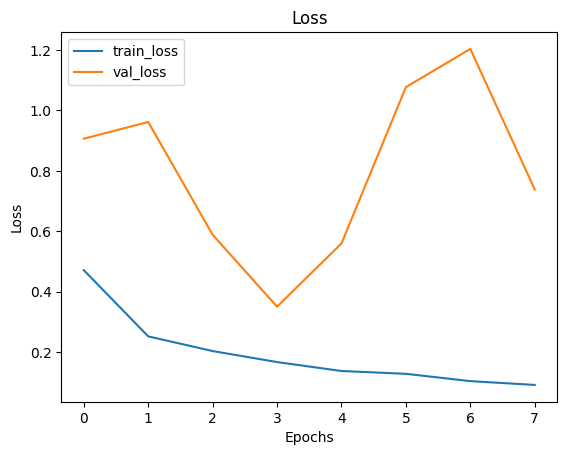

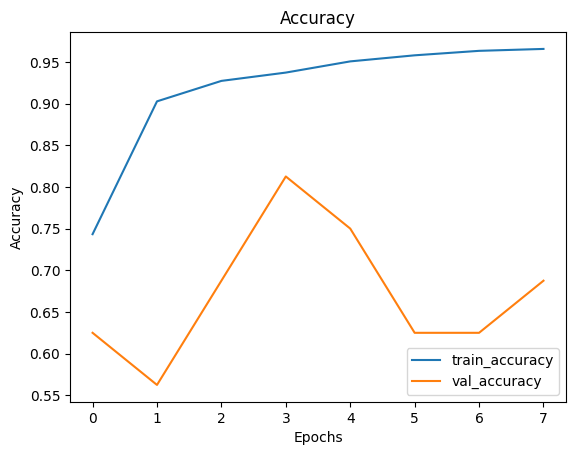

20/20 [==============================] - 0s 8ms/step


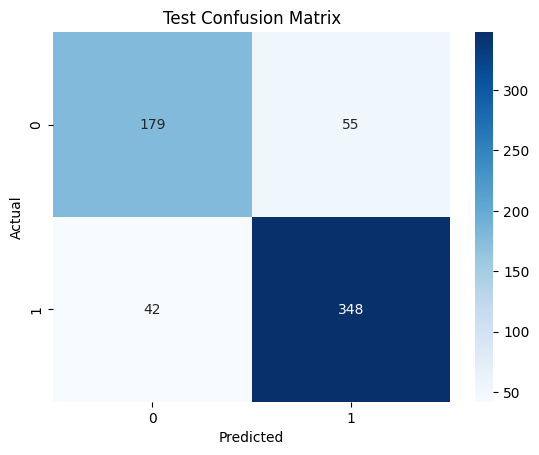

20/20 [==============================] - 0s 10ms/step - loss: 0.6152 - acc: 0.8446
------------------------------
Train Loss: 0.2531859576702118
Train Acc: 0.8901457190513611
------------------------------
Test Loss: 0.6152445673942566
Test Acc: 0.8445512652397156


In [25]:
visualize_CNN_results(history)

## Transfer Learning
Using DenseNet as our base, we'll try using our CNN on top of a pretrained model to see if we get better results.

# New Section

In [20]:
base_model = DenseNet121(input_shape=(224, 224, 3),
                         include_top=False,
                         pooling='avg')


In [21]:
model = models.Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1, padding = 'same',
                 activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))

model.add(Dropout(0.2))
model.add(Dense(1 , activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [22]:
tl_model = models.Sequential()
tl_model.add(base_model)
tl_model.add(Flatten())
tl_model.add(Dense(128, activation='relu'))
tl_model.add(Dense(1, activation='sigmoid'))

In [23]:
# Check which layers can be frozen
for layer in tl_model.layers:
  print(layer.name, layer.trainable)

print(len(tl_model.trainable_weights))

densenet121 True
flatten_3 True
dense_10 True
dense_11 True
366


In [24]:
base_model.trainable = False


In [25]:
# Check again which layers can be frozen
for layer in tl_model.layers:
  print(layer.name, layer.trainable)

print(len(tl_model.trainable_weights))

densenet121 False
flatten_3 True
dense_10 True
dense_11 True
4


In [26]:
tl_model.compile(loss='binary_crossentropy',
                optimizer='RMSprop',
                metrics=['acc'])

In [27]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]


In [28]:
results = tl_model.fit(X_train_aug,
                   y_train_aug,
                   epochs=20,
                   batch_size=32,
                   callbacks=[callbacks],
                   validation_data=(X_val, y_val))

Epoch 1/20
163/163 [==============================] - ETA: 0s - loss: 0.2868 - acc: 0.8829

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 15s 51ms/step - loss: 0.2868 - acc: 0.8829 - val_loss: 0.3593 - val_acc: 0.8750
Epoch 2/20
163/163 [==============================] - 6s 39ms/step - loss: 0.1742 - acc: 0.9321 - val_loss: 0.2720 - val_acc: 0.8750
Epoch 3/20
163/163 [==============================] - 6s 36ms/step - loss: 0.1413 - acc: 0.9433 - val_loss: 0.5260 - val_acc: 0.7500
Epoch 4/20
163/163 [==============================] - 6s 36ms/step - loss: 0.1229 - acc: 0.9507 - val_loss: 0.4554 - val_acc: 0.7500
Epoch 5/20
163/163 [==============================] - 6s 39ms/step - loss: 0.1176 - acc: 0.9532 - val_loss: 0.1356 - val_acc: 0.9375
Epoch 6/20
163/163 [==============================] - 6s 36ms/step - loss: 0.1015 - acc: 0.9601 - val_loss: 0.1664 - val_acc: 0.9375
Epoch 7/20
163/163 [==============================] - 6s 36ms/step - loss: 0.1035 - acc: 0.9586 - val_loss: 0.1719 - val_acc: 0.8750
Epoch 8/20
163/163 [==============================] - 6s 36ms/step - loss: 0.09

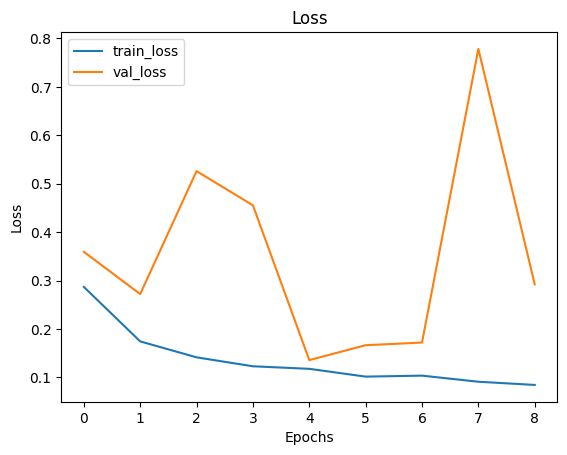

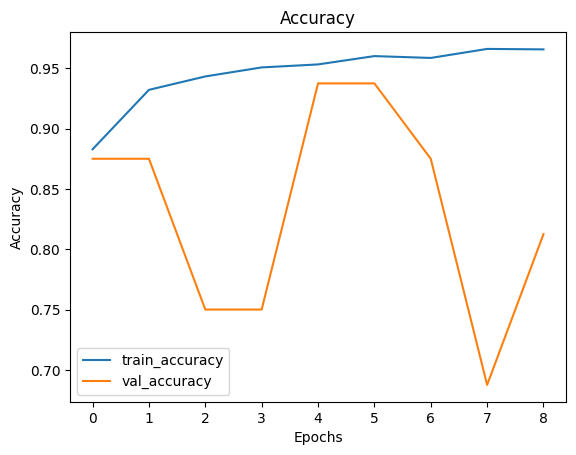

20/20 [==============================] - 0s 8ms/step


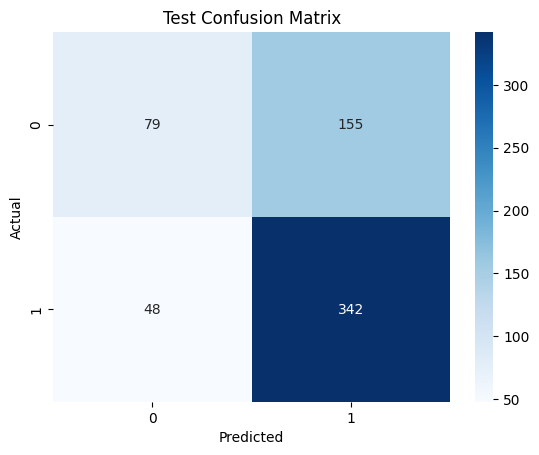

20/20 [==============================] - 1s 36ms/step - loss: 0.6139 - acc: 0.8141
------------------------------
Train Loss: 0.056562699377536774
Train Acc: 0.9785276055335999
------------------------------
Test Loss: 0.6139313578605652
Test Acc: 0.8141025900840759


In [31]:
visualize_CNN_results(results)

# Conclusions
Based on our cm numbers, it looks like our PNet with image augmentation and weights was our best model so far, with 179 TP (actual normal) and 55 FP (predicted normal), and 42 FN(predicted pneumonia), and 348 TN(actual pneumonia).  While we can be reasonably (about 80% sure) that our model will produce an accurate prediction, for this use case, we would want much better outcomes for our precision and recall before deploying our model at large.  

However, it should be noted that these rates are far better than at least one study's findings of human diagnosis: "We found a substantial error rate in the interpretation of chest x-rays. Only 59% of x-rays with consolidation were correctly diagnosed in E.D., while 14% of normal x-rays were erroneously thought to have consolidation."
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8637207/

## Next Steps

In order to employ our model at scale with confidence, we'd want to improve our models detection of pneumonia by continuing to fine tune our cutoff points and image augmentation.  

In [ ]:
# Save Model * as final model
final_cnn_path = '/content/drive/MyDrive/final_pre_trained_cnn.hd5'

model***.save(final_cnn_path)